# ECG/Resp Inspection
Processes ECG data (from files or from ICE parameters in the TWIX file) and displays time-domain plots with optionally detected events (R-peaks). Also plots respiratory signals and detects peaks/troughs for respiration.

### Loading packages and data

In [27]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import utils.data_ingestion as di
import utils.ecg_resp as ecg_resp
import scipy.signal as signal
# %matplotlib widget

def load_config(config_file="config.yaml"):
    """
    Load configuration from a YAML file.

    Parameters
    ----------
    config_file : str
        Path to the YAML configuration file.

    Returns
    -------
    dict
        Parsed configuration.
    """
    with open(config_file, "r") as f:
        return yaml.safe_load(f)

# Read config
config = load_config()

# Paths and optional file references
twix_file = config["data"]["twix_file"]
dicom_folder = config["data"]["dicom_folder"]
ecg_files = config["data"].get("ecg_files", None)
event_file = config["data"].get("event_file", None)
resp_file = config["data"].get("resp_file", None)

# Read TWIX, extract raw k-space, and derive sampling frequency
scans = di.read_twix_file(twix_file, include_scans=[-1], parse_pmu=False)

Software version: VD/VE (!?)

Scan  1


100%|██████████| 287M/287M [00:00<00:00, 2.36GB/s]

Read 1 scans from 20250307_JM/raw/meas_MID00115_FID27380_Cor_250306_2.dat


### Extracting and analyzing ECG

In [28]:
# first_time = None
# last_time = None
# for (i,mdb) in enumerate(scans[-1]['mdb']):
#     if mdb.is_image_scan():
#         print(mdb.mdh.TimeStamp)
#         last_time = mdb.mdh.TimeStamp
#         if first_time is None:
#             first_time = mdb.mdh.TimeStamp

# print("First time: ", first_time)
# print("Last time: ", last_time)
# print("Time difference: ", (last_time - first_time) * 2.5e-3)

In [29]:
kspace = di.extract_image_data(scans)

framerate, frametime = di.get_dicom_framerate(dicom_folder)
n_phase_encodes_per_frame = kspace.shape[0] // config["data"]["n_frames"]
fs = framerate * n_phase_encodes_per_frame  # ECG / respiration sampling freq
# fs = 1/(scans[-1]['hdr']['Phoenix']['alTR'][0]/1000/48/1000)

# Load ECG data either from external files or from the ICE parameters
if ecg_files:
    # Concatenate multi-file ECG data channel-wise
    ecg_data = []
    for ecg_file in ecg_files:
        raw_ecg = np.loadtxt(ecg_file, skiprows=1, usecols=1)
        ecg_data.append(signal.resample(raw_ecg, kspace.shape[0]))
    ecg_data = np.vstack(ecg_data).T
else:
    ecg_columns = np.s_[18:21]
    ecg_data = di.extract_iceparam_data(scans, segment_index=0, columns=ecg_columns)
    # Force 2D shape
    if ecg_data.ndim == 1:
        ecg_data = ecg_data.reshape(-1, 1)

Extracted image data shape: (4800, 30, 256)


In [30]:
# Example (commented) R-peak detection
# r_peaks_list = ecg_resp.detect_r_peaks(ecg_data, fs)
# hr = ecg_resp.compute_average_heart_rate(r_peaks_list, fs)
# print(f"Average heart rate: {hr:.2f} BPM")

# If event_file is present, interpret it as R-peak triggers or some other event
if event_file:
    resampled_length = kspace.shape[0]
    raw_events = np.loadtxt(event_file, skiprows=1, usecols=1)
    # Normalize events so that non-zero remain as spikes
    raw_events = raw_events - np.min(raw_events)
    raw_length = len(raw_events)

    # Create empty, then place spikes based on global fraction
    resampled_events = np.zeros(resampled_length)
    raw_spike_indices = np.nonzero(raw_events)[0]
    resampled_spike_indices = np.round(
        raw_spike_indices / (raw_length - 1) * (resampled_length - 1)
    ).astype(int)

    for (raw_idx, resampled_idx) in zip(raw_spike_indices, resampled_spike_indices):
        resampled_events[resampled_idx] = raw_events[raw_idx]
else:
    resampled_events = None

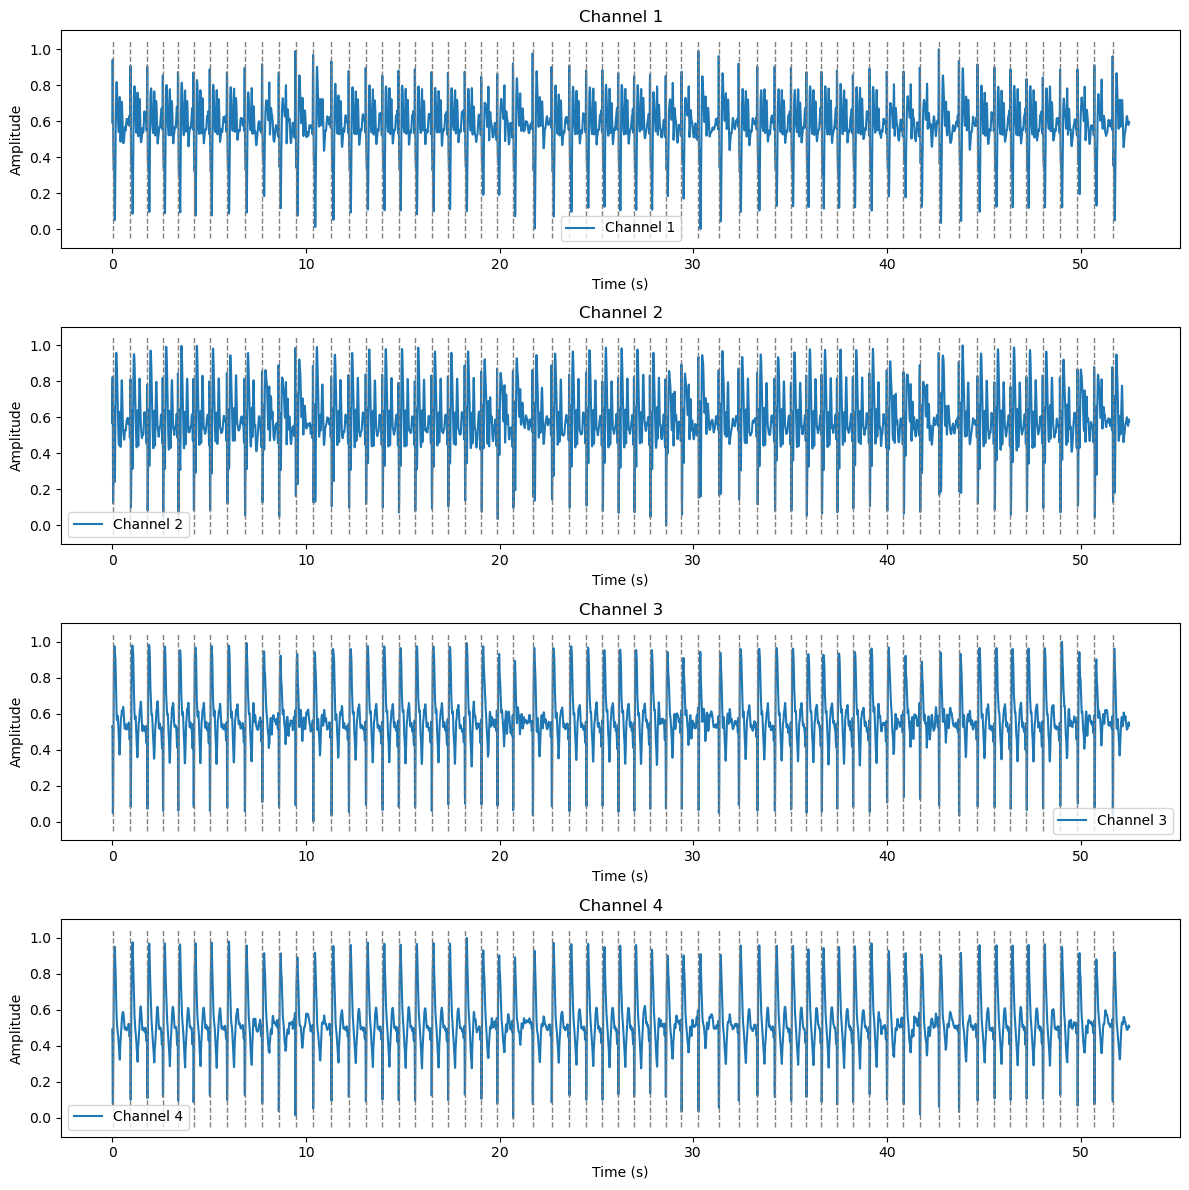

In [31]:
# Normalize ECG
ecg_data = (ecg_data - np.min(ecg_data, axis=0)) / (
    np.ptp(ecg_data, axis=0) + 1e-9
)

# Plot ECG with optional event spikes as vertical lines
ecg_resp.plot_ecg_signals(ecg_data, fs, spike_indices=np.nonzero(resampled_events)[0] if resampled_events is not None else None, mode="separate")

### Extracting and analyzing resp

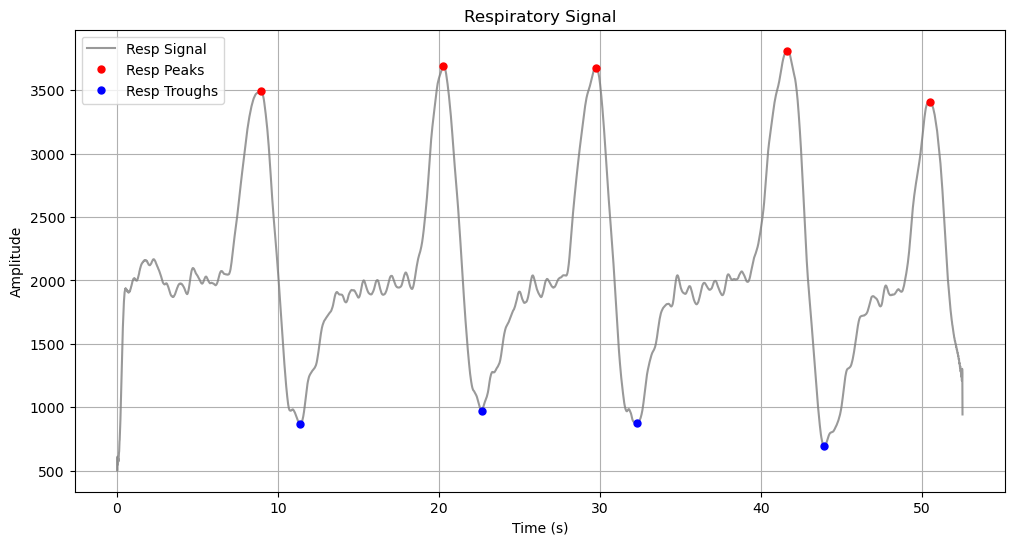

In [32]:
# If a respiratory file is present, load and detect peaks/troughs
if resp_file:
    resp_data = np.loadtxt(resp_file, skiprows=1, usecols=1)
    # Resample to match the total number of k-space time points
    resp_data = signal.resample(resp_data, kspace.shape[0])[:, np.newaxis]

    resp_peaks = ecg_resp.detect_resp_peaks(resp_data, fs, method='scipy', height=0.6, prominence=0.2)
    resp_troughs = ecg_resp.detect_resp_peaks(-resp_data, fs, method='scipy', height=0.6, prominence=0.2)

    # Plot
    ecg_resp.plot_resp_signal(resp_data, fs, resp_peaks=resp_peaks, resp_troughs=resp_troughs)

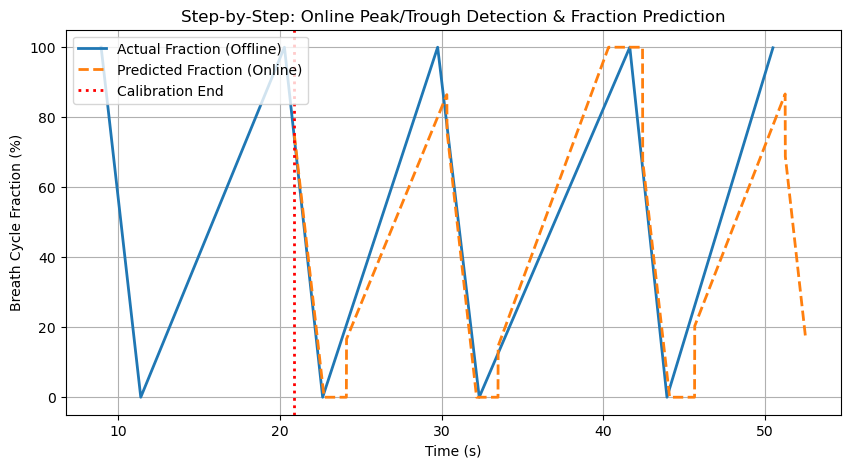

Calibration finished at sample 1909 (t=20.89 s).
Final average inhalation ~ 7.97s, exhalation ~ 2.42s.


In [88]:
import numpy as np
import matplotlib.pyplot as plt

# We'll use your existing detection function from utils.ecg_resp:
from utils.ecg_resp import detect_resp_peaks

# Flatten the respiration signal
resp_signal = resp_data.flatten()
N = len(resp_signal)

# Sampling frequency from your notebook
# fs = ...  # Must already be defined

# -------------------------------------------------------------------------
# Helper function: given sorted boundaries + labels, find all full cycles
# Each cycle is either:
#   trough -> peak   (inhalation)
#   peak   -> trough (exhalation)
# We collect durations, e.g. (start_idx, end_idx, 'inhalation'/'exhalation').
# -------------------------------------------------------------------------
def extract_cycles(boundary_indices, boundary_labels):
    """
    boundary_indices : np.ndarray of sorted boundary indices
    boundary_labels  : array of same length, each label is 'peak' or 'trough'
    Returns: list of (start_idx, end_idx, 'inhalation' or 'exhalation')
    """
    cycles = []
    for i in range(len(boundary_indices) - 1):
        s_idx = boundary_indices[i]
        e_idx = boundary_indices[i+1]
        s_lab = boundary_labels[i]
        e_lab = boundary_labels[i+1]
        if s_lab == 'trough' and e_lab == 'peak':
            cycles.append((s_idx, e_idx, 'inhalation'))
        elif s_lab == 'peak' and e_lab == 'trough':
            cycles.append((s_idx, e_idx, 'exhalation'))
    return cycles

# -------------------------------------------------------------------------
# Helper function: from cycles, compute average inhalation & exhalation durations (in seconds).
# -------------------------------------------------------------------------
def compute_avg_durations(cycles, fs):
    inhalation_lengths = []
    exhalation_lengths = []
    for (start_i, end_i, phase) in cycles:
        if end_i > start_i:  
            duration_sec = (end_i - start_i)/fs
            if phase == 'inhalation':
                inhalation_lengths.append(duration_sec)
            else:
                exhalation_lengths.append(duration_sec)
    avg_inhale = np.mean(inhalation_lengths) if len(inhalation_lengths) > 0 else None
    avg_exhale = np.mean(exhalation_lengths) if len(exhalation_lengths) > 0 else None
    return avg_inhale, avg_exhale

# -------------------------------------------------------------------------
# Helper to figure out if we have at least 2 "full cycles"
# The user wants e.g. peak->trough->peak->trough->peak or trough->peak->trough->peak->trough
# effectively: we want at least 5 boundaries in alternating pattern (or 4 transitions).
# But simpler: if we have at least 2 cycles in `cycles` => done.
# -------------------------------------------------------------------------
def have_two_full_cycles(cycles):
    return len(cycles) >= 2

# -------------------------------------------------------------------------
# Build an "actual fraction" array purely for final plotting
# (In real time you wouldn't have this. It's just to visualize accuracy.)
# -------------------------------------------------------------------------
def build_true_fraction(signal_length, all_peaks, all_troughs):
    # Combine and sort
    all_extrema = np.concatenate((all_peaks, all_troughs))
    if len(all_extrema) == 0:
        return np.full(signal_length, np.nan)
    sort_idx = np.argsort(all_extrema)
    sorted_bdry = all_extrema[sort_idx]
    labels = []
    for b in sorted_bdry:
        if b in all_peaks:
            labels.append('peak')
        else:
            labels.append('trough')
    labels = np.array(labels, dtype=object)
    
    # Extract cycles
    cyc = extract_cycles(sorted_bdry, labels)
    actual_frac = np.full(signal_length, np.nan)
    for (si, ei, ph) in cyc:
        if ei <= si: 
            continue
        length = ei - si
        for x in range(si, min(ei, signal_length)):
            if ph == 'inhalation':
                # For inhalation: ramp up from 0 at trough to 100 at peak.
                frac = 100.0 * (x - si) / float(length)
            elif ph == 'exhalation':
                # For exhalation: ramp down from 100 at peak to 0 at trough.
                frac = 100.0 * (1.0 - (x - si) / float(length))
            else:
                frac = np.nan
            actual_frac[x] = frac
    return actual_frac


# Build offline "actual_fraction" from all final data. This is just for plotting.
actual_fraction = build_true_fraction(N, resp_peaks, resp_troughs)

# We'll store predicted fraction for each sample
predicted_fraction = np.full(N, np.nan)

calibration_done = False
calibration_end_idx = None

# For the last boundary logic:
last_boundary_idx = None   # The index of last peak/trough
last_boundary_label = None # 'peak' or 'trough'

avg_inhale = None
avg_exhale = None

# ---------------------------------------------------------
# MAIN TIME-STEP LOOP
# ---------------------------------------------------------
for k in range(N):
    # 1) One step forward: partial_data = up to index k
    partial_data = resp_signal[:k+1]

    # 2) Detect peaks/troughs on partial_data
    partial_peaks = detect_resp_peaks(partial_data, fs, method='scipy', height=0.6, prominence=0.2)
    partial_troughs = detect_resp_peaks(-partial_data, fs, method='scipy', height=0.6, prominence=0.2)

    # Label them
    # Combine and sort
    boundaries = np.concatenate((partial_peaks, partial_troughs))
    sort_idx = np.argsort(boundaries)
    boundaries = boundaries[sort_idx]
    labels = []
    for b in boundaries:
        labels.append('peak' if b in partial_peaks else 'trough')
    labels = np.array(labels, dtype=object)

    # 3) Build the cycles from these boundaries
    cycles = extract_cycles(boundaries, labels)

    # 4) Check if we have at least 2 cycles => calibration done
    if (not calibration_done) and have_two_full_cycles(cycles) and k / fs > 10:
        calibration_done = True
        calibration_end_idx = k  # we say calibration ended at sample k

    if not calibration_done:
        # If not calibrated, skip prediction
        predicted_fraction[k] = np.nan
        continue

    # If we are here => calibration is done => we can predict
    # 5) Recompute average inhale/exhale from *all* cycles so far
    new_avg_inhale, new_avg_exhale = compute_avg_durations(cycles, fs)
    # We'll keep them if they exist, otherwise fallback to old
    if new_avg_inhale is not None:
        avg_inhale = new_avg_inhale
    if new_avg_exhale is not None:
        avg_exhale = new_avg_exhale

    # If still None, we can't predict
    if (avg_inhale is None) or (avg_exhale is None):
        predicted_fraction[k] = np.nan
        continue

    # 6) Identify the most recent boundary in partial_data
    if len(boundaries) == 0:
        # no boundaries => can't do anything
        predicted_fraction[k] = np.nan
        continue
    else:
        last_boundary_idx = boundaries[-1]
        last_boundary_label = labels[-1]  # 'peak' or 'trough'

    # If the last boundary is a trough => we are inhaling now
    # If the last boundary is a peak => we are exhaling
    # We'll linearly ramp from that boundary to boundary + avg_inhale or boundary + avg_exhale
    if last_boundary_label == 'trough':
        # inhalation
        expected_end = last_boundary_idx + int(round(avg_inhale*fs))
    else:
        # exhalation
        expected_end = last_boundary_idx + int(round(avg_exhale*fs))

    # current fraction = 100 * (k - last_boundary_idx) / (expected_end - last_boundary_idx)
    denom = expected_end - last_boundary_idx
    if denom < 1:
        denom = 1
    if last_boundary_label == 'trough':
        # Inhalation: phase fraction ramps from 0% at the trough to 100% at the peak.
        expected_end = last_boundary_idx + int(round(avg_inhale * fs))
        frac = 100.0 * (k - last_boundary_idx) / float(expected_end - last_boundary_idx)
    elif last_boundary_label == 'peak':
        # Exhalation: phase fraction ramps from 100% at the peak to 0% at the trough.
        expected_end = last_boundary_idx + int(round(avg_exhale * fs))
        frac = 100.0 * (1.0 - (k - last_boundary_idx) / float(expected_end - last_boundary_idx))
    else:
        frac = np.nan

    # Clamp fraction between 0 and 100.
    frac = max(0, min(100, frac))
    predicted_fraction[k] = frac


# ---------------------------------------------------------
# Plot results
# ---------------------------------------------------------
t = np.arange(N)/fs
plt.figure(figsize=(10,5))
plt.plot(t, actual_fraction, label='Actual Fraction (Offline)', linewidth=2)
plt.plot(t, predicted_fraction, '--', label='Predicted Fraction (Online)', linewidth=2)

if calibration_end_idx is not None:
    plt.axvline(calibration_end_idx/fs, color='r', linestyle=':', linewidth=2,
                label='Calibration End')

plt.title("Step-by-Step: Online Peak/Trough Detection & Fraction Prediction")
plt.xlabel("Time (s)")
plt.ylabel("Breath Cycle Fraction (%)")
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

if calibration_done and calibration_end_idx is not None:
    print(f"Calibration finished at sample {calibration_end_idx} (t={calibration_end_idx/fs:.2f} s).")
    print(f"Final average inhalation ~ {avg_inhale:.2f}s, exhalation ~ {avg_exhale:.2f}s.")
else:
    print("Never finished calibration (not enough cycles detected).")
